# Autoencoder for cdr3 lenghts 15-20

In [1]:
import peptides
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from scipy.stats import entropy
#from umap import UMAP

# my module with some func
import pepcode

## Set parameters

In [2]:
AA_LIST = pepcode.AA_LIST

latent_dims = 200
num_epochs = 200
batch_size = 300
learning_rate = 1e-4 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Preparing data

In [3]:
data = pd.read_csv('./dataset/vdjdb-2024-11-27-fixed/vdjdb.slim.txt', sep = '\t')
data = data[(data.gene == 'TRB') & (data.species == 'HomoSapiens')]
data.reset_index(drop=True, inplace=True)
index_list = []
for i in range(len(data)):
    if len(data.iloc[i].cdr3) >= 15 and len(data.iloc[i].cdr3) <=20 and data.iloc[i].cdr3[0]=='C' and (data.iloc[i].cdr3[-1]=='F' or data.iloc[i].cdr3[-1]=='W'):
        continue
    else:
        index_list.append(i)
data.drop(index=index_list, inplace=True)



col_to_insert = []
for i in range(data.shape[0]):
    if len(data.iloc[i].cdr3) == 20:
        col_to_insert.append(data.iloc[i].cdr3)
    elif len(data.iloc[i].cdr3) == 19:
        col_to_insert.append(data.iloc[i].cdr3[0:3] + '-' + data.iloc[i].cdr3[3:])
    elif len(data.iloc[i].cdr3) == 18:
        col_to_insert.append(data.iloc[i].cdr3[0:3] + '-' + data.iloc[i].cdr3[3:15] + '-' + data.iloc[i].cdr3[15:18])
    elif len(data.iloc[i].cdr3) == 17:
        col_to_insert.append(data.iloc[i].cdr3[0:3] + '--' + data.iloc[i].cdr3[3:14]+ '-' + data.iloc[i].cdr3[14:17])
    elif len(data.iloc[i].cdr3) == 16:
        col_to_insert.append(data.iloc[i].cdr3[0:3] + '--' + data.iloc[i].cdr3[3:13] + '--' + data.iloc[i].cdr3[13:16])
    elif len(data.iloc[i].cdr3) == 15:
        col_to_insert.append(data.iloc[i].cdr3[0:3] + '---' + data.iloc[i].cdr3[3:12] + '--' + data.iloc[i].cdr3[12:15])

data = data.assign(cdr3_norm=col_to_insert)
data = shuffle(data)
data.reset_index(drop=True, inplace=True)

#Split dataset and prepare train, test, evaluation datasets
train_size, test_size, eval_size = int(round(len(data)*0.7, 0)), int(round(len(data)*(0.7+0.15), 0)), int(round(len(data)*(1), 0))
data_split = np.split(data, [train_size, test_size, eval_size], axis=0)
data_train = data_split[0]
data_test = data_split[1]
data_eval = data_split[2]

# Prepare peptide lists
pep_train_list = data_train.cdr3_norm.values
pep_test_list = data_test.cdr3_norm.values
pep_eval_list = data_eval.cdr3_norm.values


len_seq = len(pep_train_list[0])


pep_train_oh = np.zeros((len(pep_train_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_oh)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

pep_test_oh = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])  

pep_eval_oh = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])  



oh_matr_size = pep_test_oh[0].size


# Prepare train dataloader
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_train_dl = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=False)

# Prepare test dataloader
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_test_dl = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation (пока не нужно)
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_eval_dl = torch.utils.data.DataLoader(oh_dataset_eval, batch_size=batch_size, shuffle=False)


/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Autoencoder definition

In [4]:
autoencoder_arch = '300->200'

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200),
            # nn.ReLU(),
            # nn.Linear(in_features=700, out_features=500),
            # nn.ReLU(),
            # nn.Linear(in_features=500, out_features=200),
        )
        self.decoder = nn.Sequential(
            # nn.Linear(in_features=200, out_features=500),
            # nn.ReLU(),
            # nn.Linear(in_features=500, out_features=700),
            # nn.ReLU(),
            nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate)

### Train autoencoder

In [5]:
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_train_dl:
        
        pep_batch = pep_batch.to(device)
        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    if epoch % 50 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Epoch [1 / 200] average reconstruction error: 0.230605
Epoch [51 / 200] average reconstruction error: 0.014544
Epoch [101 / 200] average reconstruction error: 0.005071
Epoch [151 / 200] average reconstruction error: 0.001590
Train finished


### Evaluation on test set

In [24]:
autoencoder.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

for (pep, _) in oh_test_dl:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i], mode = 'entropy', entropy_threshold = 2.5))  
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i], mode = 'entropy', entropy_threshold = 2.5))



Average reconstruction error: 0.000049


#### Biological evaluatiuon

In [25]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            #blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


# avg_blos_score = {}
# for i in range(len_seq):
#     if err_count[i] !=0:
#         avg_blos_score[i]=blos_score[i]/err_count[i]

err_dict = {}
for i in range(len(pep_test_list_aft_ae)):
    for j in range(len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        if  aa_before != aa_after:
            if aa_before+aa_after in err_dict.keys():
                err_dict[aa_before+aa_after] += 1
            else:
                err_dict[aa_before+aa_after] = 1
err_dict = dict(sorted(err_dict.items(), key=lambda item: item[1]))

err_dict_hf = {}
for i in err_dict.keys():
    if err_dict[i] > 6:
        err_dict_hf[i] = err_dict[i]

pep_test_list_bef_ae_aa = []
pep_test_list_aft_ae_aa = []
for i in range(len(pep_test_list_bef_ae)):
    for j in pep_test_list_bef_ae[i]:
        pep_test_list_bef_ae_aa.append(j)
    for k in pep_test_list_aft_ae[i]:
        pep_test_list_aft_ae_aa.append(k)

/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

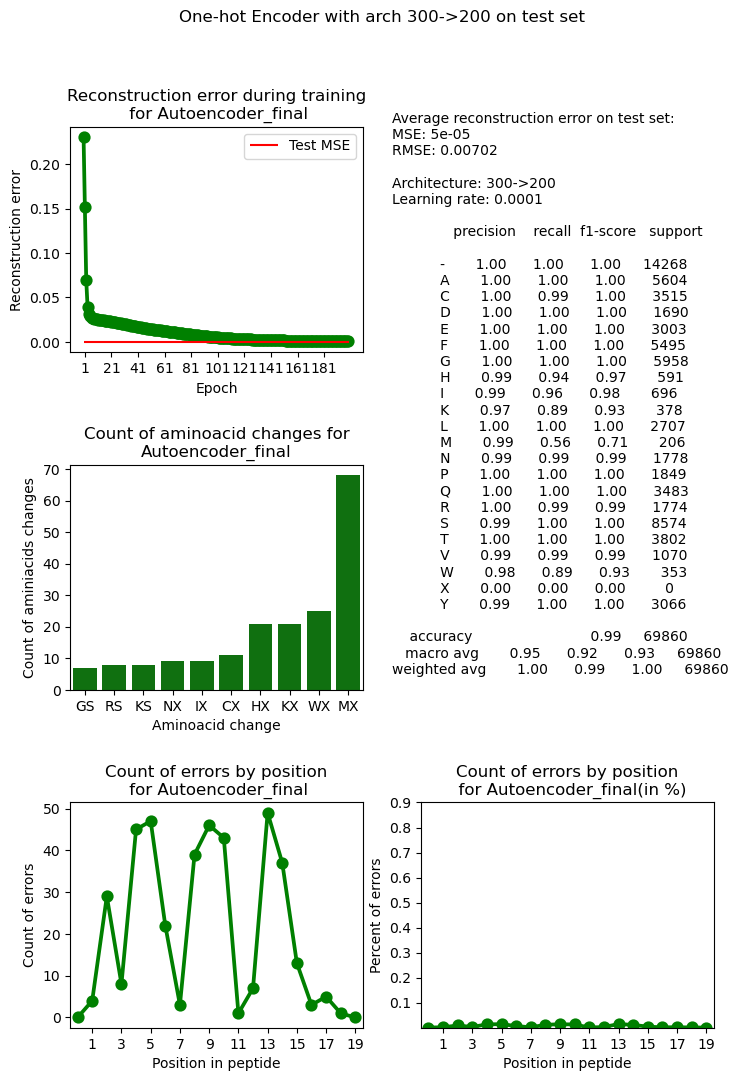

In [26]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg , color = 'green', ax=axs[0, 0])
sns.barplot(err_dict_hf, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count, color = 'green', ax=axs[2, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[2, 1])

axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSE')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_final', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}\n\n{classification_report(pep_test_list_bef_ae_aa, pep_test_list_aft_ae_aa)}')
axs[1, 0].set(xlabel='Aminoacid change', ylabel='Count of aminiacids changes', title=f'Count of aminoacid changes for\nAutoencoder_final')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_final')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_final(in %)', yticks=[i/10 for i in range(1, 10)])
axs[2, 0].set_xticks([i for i in range(1, len_seq, int(len_seq/10))])
axs[2, 1].set_xticks([i for i in range(1, len_seq, int(len_seq/10))])


plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig.suptitle(f'One-hot Encoder with arch {autoencoder_arch} on test set') 
plt.show()
#fig.savefig(f'./Results_one_hot/{str(date.today())}_final_{autoencoder_arch}_on_test.pdf', format='pdf')